# Fatigue Analysis of Timeseries Data using pylife

This notebook demonstrates how to perform a fatigue analysis on timeseries data using the pylife library. The steps include:

1. **Import Required Libraries**: Import necessary libraries such as pylife, pandas, and matplotlib.
2. **Load Timeseries Data**: Load the timeseries data from a file or other data source.
3. **Preprocess Data**: Clean and preprocess the data to ensure it is in the correct format for analysis.
4. **Perform Fatigue Analysis**: Use pylife's functions to analyze the fatigue life of the material based on the timeseries data.
5. **Visualize Results**: Plot the results of the fatigue analysis to visualize the fatigue life and other relevant metrics.

By following these steps, you will be able to assess the fatigue life of materials subjected to varying loads over time.

**1.Import Required Libraries**

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, medfilt
import pylife.stress.rainflow as rf
from pylife.materiallaws import WoehlerCurve
import sys
sys.path.append('../')
from tools.helper_functions import plot_rf

**2.Load Timeseries Data**

,elapsed time,receive time,header.stamp,topic,value
0,0.000000,1.740058e+09,1.740058e+09,/imu/data.linear_acceleration.y,10.634629
1,0.050843,1.740058e+09,1.740058e+09,/imu/data.linear_acceleration.y,10.487325
2,0.102743,1.740058e+09,1.740058e+09,/imu/data.linear_acceleration.y,10.438822
3,0.151645,1.740058e+09,1.740058e+09,/imu/data.linear_acceleration.y,10.447804
4,0.200515,1.740058e+09,1.740058e+09,/imu/data.linear_acceleration.y,10.390320


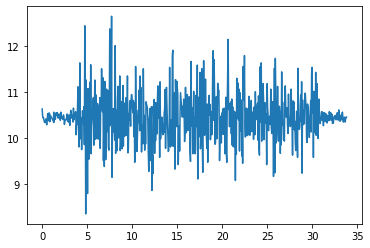

In [62]:
# Load the CSV data into a pandas dataframe by defining the values

profile_num = 1 # 1, 2, 3
wanted_speed = 0.4 # 0.4 1
wanted_freq = 20 # 20 27 45 62

df = pd.read_csv(f'../data/IMU_data_profile{profile_num}/acc_y_{profile_num}_{wanted_speed}_{wanted_freq}.csv')
display(df.head())
plt.plot(df['elapsed time'], df['value'])


**3.Preprocess Data**

In [63]:
def lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [64]:
def detect_spikes(data, threshold):
    spikes = data[np.abs(data.diff()) > threshold]
    return spikes

In [65]:
def remove_spikes(data, threshold):
    spikes = detect_spikes(data, threshold)
    data_cleaned = data.copy()
    data_cleaned[spikes.index] = np.nan
    return data_cleaned

In [66]:
def interpolate_data(data):
    return data.interpolate()

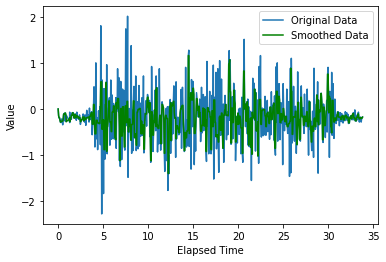

Variance of the rough component: 0.22532821618440949


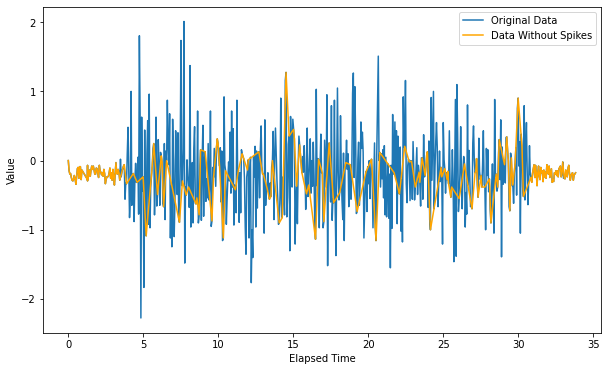

In [67]:
# Get Offset out of the data
offset = df['value'].iloc[0]
df['value'] = df['value'] - offset

# Shorten Time Series
filtered_df = df[(df['elapsed time'] >= 0) & (df['elapsed time'] <= 45)]

# Spike Detection
fs = wanted_freq # Hz
# cutoff = 1 # Hz

# # # Smooth the Data
# filtered_df['smoothed_value'] = lowpass_filter(filtered_df['value'], cutoff, fs)

kernel_size = 3  # Adjust the kernel size as needed

# Smooth the Data using a median filter
filtered_df['smoothed_value'] = medfilt(filtered_df['value'], kernel_size=kernel_size)

# # Calc the rough part
filtered_df['rough_value'] = filtered_df['value'] - filtered_df['smoothed_value']

# # Calc the variance of the rough part
rough_variance = filtered_df['rough_value'].var()

plt.plot(filtered_df['elapsed time'], filtered_df['value'], label='Original Data')
plt.plot(filtered_df['elapsed time'], filtered_df['smoothed_value'], label='Smoothed Data', color='green')
plt.xlabel('Elapsed Time')
plt.ylabel('Value')
plt.legend()
plt.show()

print(f"Variance of the rough component: {rough_variance}")
threshold = rough_variance
filtered_df['value_cleaned'] = remove_spikes(filtered_df['value'], threshold)
filtered_df['value_interpolated'] = interpolate_data(filtered_df['value_cleaned'])

plt.figure(figsize=(10, 6))
plt.plot(filtered_df['elapsed time'], filtered_df['value'], label='Original Data')
plt.plot(filtered_df['elapsed time'], filtered_df['value_interpolated'], label='Data Without Spikes', color='orange')
plt.xlabel('Elapsed Time')
plt.ylabel('Value')
plt.legend()
plt.show()

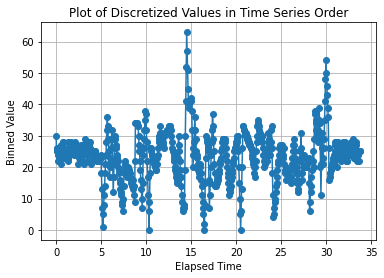

In [68]:
# Diskretsierung
num_bins = 64
bins = np.linspace(filtered_df['value_interpolated'].min(), filtered_df['value_interpolated'].max(), num_bins + 1)
filtered_df['binned_value'] = pd.cut(filtered_df['value_interpolated'], bins, labels=False, include_lowest=True)
plt.plot(filtered_df['elapsed time'], filtered_df['binned_value'], marker='o')
plt.xlabel('Elapsed Time')
plt.ylabel('Binned Value')
plt.title('Plot of Discretized Values in Time Series Order')
plt.grid(True)
plt.show()

**4.Perform Fatigue Analysis**

*Rainflow Matrix*

..\tools\helper_functions.py:26: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  ax.bar3d(froms.ravel(), tos.ravel(), bottom, width, depth, rf_series,


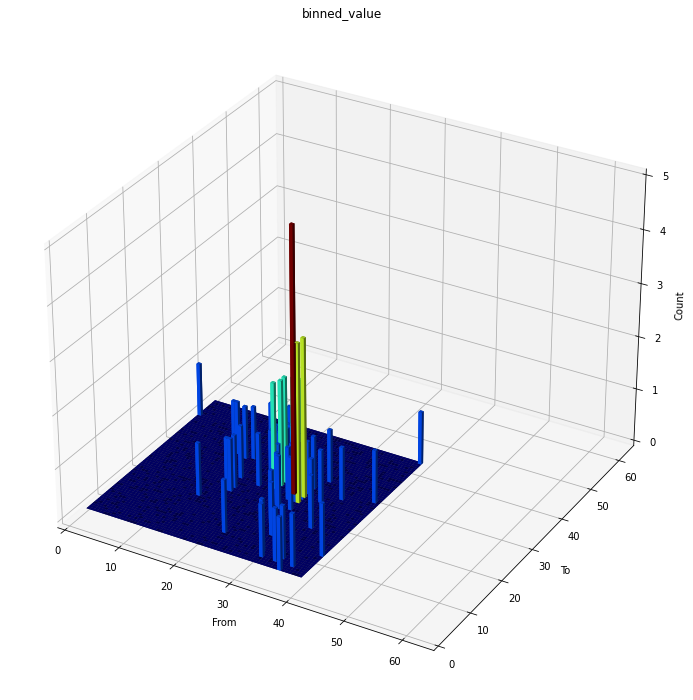

In [69]:
# Rainflow Counting
rainflow_bins=num_bins

detector = rf.FourPointDetector(recorder=rf.LoopValueRecorder())
detector.process(filtered_df['binned_value'])
histogram = detector.recorder.histogram(rainflow_bins)

f = plot_rf({'binned_value': histogram}, num_bins)

collective = detector.recorder.collective
# fr, to = histogram.index.levels[0], histogram.index.levels[1]
# numpy_hist = np.flipud(histogram.values.reshape(len(fr),len(to)))
# X, Y = np.meshgrid(fr.left, to.left)
# plt.pcolormesh(X, Y, numpy_hist)


*Interpretation der Rainflow Matrix*

In [70]:
# Level Crossing

[]

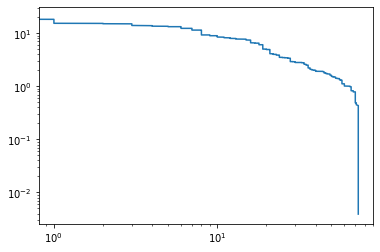

In [71]:
# Range Pair Method

df = pd.DataFrame({
'cycles': histogram.load_collective.cycles,
'amplitude': histogram.load_collective.amplitude,
}).sort_values('amplitude', ascending=False)

plt.plot(np.cumsum(df.cycles), df.amplitude)
plt.loglog()

*Pseudo Damage*

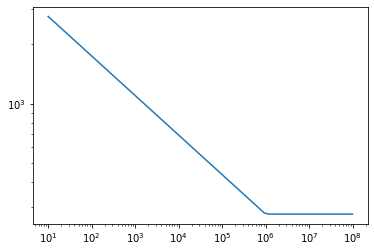

In [72]:
# Pseudo - Damage
# 𝑘=5 for non-welded steel components
# take a "pseudo" - Woehler Kurve 
# Hier wurde exemplarisch eine Woehler Kurve gewählt (wie in Folien beschrieben wurde k=5 gewählt)

# Parameter für die Wöhlerkurve von 6061-T6 Aluminium (vermutlich eine Annährung)
woehler_curve_data = pd.Series({
   'SD': 276.0,  # Yield Strength (Zugstreckgrenze) in MPa
   'ND': 1e6,    # Number of cycles to failure at fatigue limit
   'k_1': 5      # Basquin exponent (Wöhlerexponent)
})

cycles = np.logspace(1., 8., 70)
load = woehler_curve_data.woehler.load(cycles)
plt.plot(cycles, load)
plt.loglog()
plt.show()

*Analyse im Frequenzbereich*

In [73]:
# PSD

*Analyse der Wankbewegung*